In [1]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm


In [2]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


In [3]:
from konlpy.tag import Okt
import re

# 불용어 정의
stop_words = ['가','요','변','을','수','에','문','제','를','이','도','은','다','게','요','한','일','할','인데','거','좀','는데']

# 형태소 분석기 초기화
okt = Okt()

# 토큰화 함수
def preprocess_text(text):
    # 정규화 (한글 외 문자 제거)
    text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)
    
    # 형태소 분석
    tokens = okt.morphs(text, stem=True)
    
    # 불용어 제거
    tokens = [word for word in tokens if not word in stop_words]
    
    return tokens

# 예시 데이터
texts = ['한국어 텍스트 예시입니다', '단어 임베딩을 시각화해 봅시다']
tokenized_data = [preprocess_text(text) for text in texts]


In [4]:
# Word2Vec 모델 학습
model = Word2Vec(sentences=tokenized_data, 
                 vector_size=100,  # 벡터 차원
                 window=5,         # 컨텍스트 윈도우 크기
                 min_count=1,      # 최소 단어 빈도
                 workers=4)        # 병렬 처리 스레드 수

# 모델 저장
model.save('word2vec_model.model')

# 필요시 모델 로드
# model = Word2Vec.load('word2vec_model.model')


In [5]:
model.wv.index_to_key

['보다', '화해', '시각', '임베딩', '단어', '이다', '예시', '텍스트', '한국어']

9


/opt/anaconda3/envs/w2v/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipy

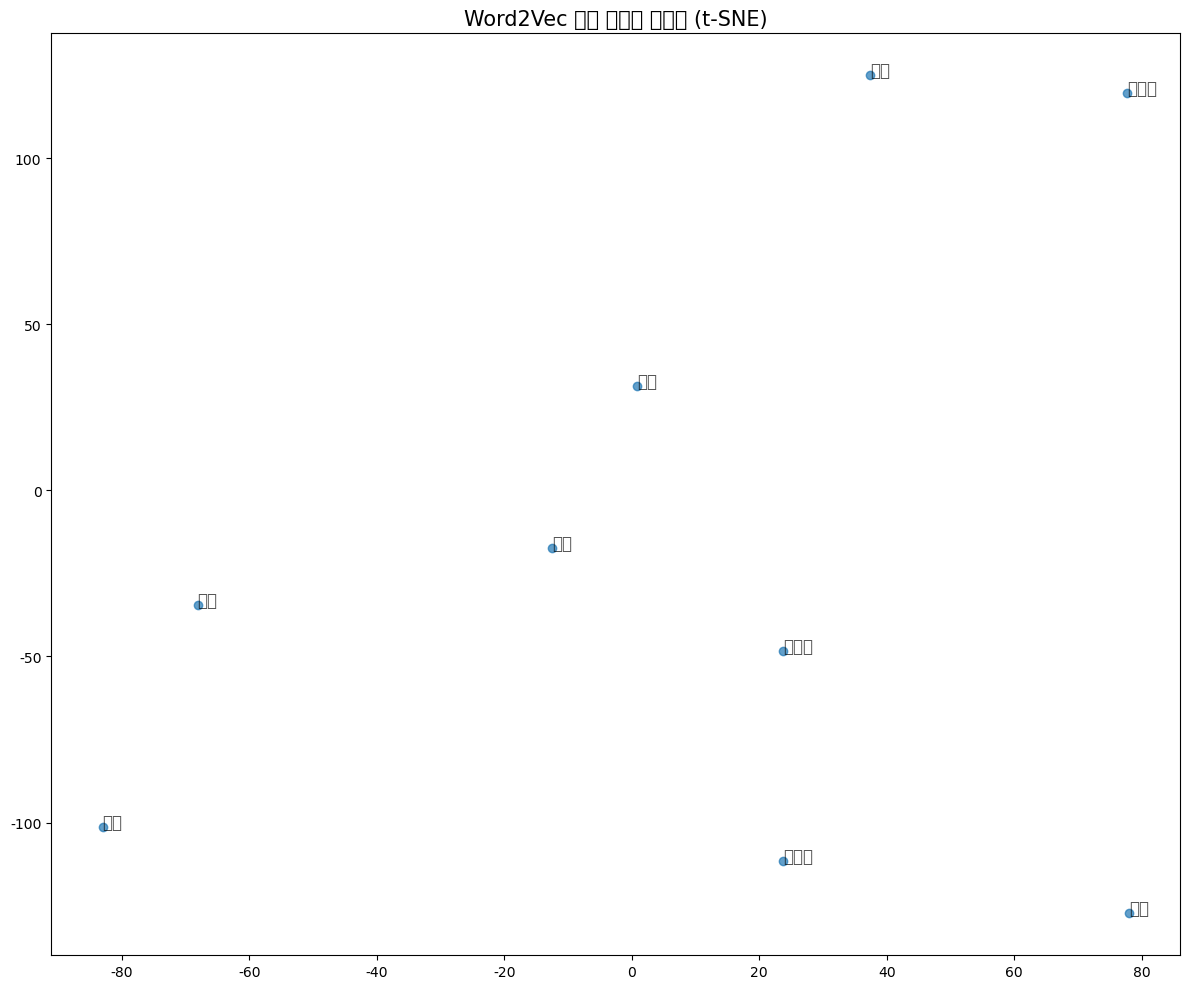

In [6]:
def visualize_words(model, words=None, topn=100):
    # 모든 단어 벡터 가져오기

    if words is not None:
        words = [word for word in model.wv.index_to_key[:topn]]
    else:
        # 모델에 존재하는 단어만 필터링
        words = [word for word in words if word in model.wv]
        
    
    # 단어 벡터 추출
    word_vectors = np.array([model.wv[word] for word in words])
    print(len(word_vectors))
    
    # t-SNE 적용
    tsne = TSNE(random_state=42, n_iter=1000, perplexity=3)
    embeddings = tsne.fit_transform(word_vectors)
    
    # 데이터프레임 생성
    df = pd.DataFrame(embeddings, index=words, columns=['x', 'y'])
    
    # 그래프 생성
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 산점도 그리기
    ax.scatter(df['x'], df['y'], alpha=0.7)
    
    # 단어 레이블 추가
    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=12, alpha=0.7)
    
    plt.title('Word2Vec 단어 임베딩 시각화 (t-SNE)', fontsize=15)
    plt.tight_layout()
    plt.show()

# 예시: 모든 단어 시각화
#visualize_words(model)

# 특정 단어들만 시각화 (충분한 수의 단어 제공)
specific_words = ['한국', '서울', '도쿄', '일본', '컴퓨터', '프로그램', 
                 '영화', '음악', '스포츠', '경제', '정치', '문화',
                 '학교', '대학', '회사', '기업', '기술', '과학']
visualize_words(model, specific_words)


In [7]:
import os
import platform
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import sys

# 시스템 확인
system = platform.system()
print(f"운영체제: {system}")

# 현재 사용 가능한 폰트 확인
def find_available_korean_fonts():
    korean_fonts = []
    for font in fm.fontManager.ttflist:
        if any(keyword in font.name.lower() for keyword in ['gothic', '고딕', 'gulim', '굴림', 'batang', '바탕', 'malgun', '맑은', 'nanum', '나눔']):
            korean_fonts.append(font.name)
    return sorted(set(korean_fonts))

available_korean_fonts = find_available_korean_fonts()
print("\n사용 가능한 한글 폰트:")

운영체제: Darwin

사용 가능한 한글 폰트:
